<a href="https://colab.research.google.com/github/Yospy/Email-Classification-Using-BERT/blob/main/Email_Classifier_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [2]:
import pandas as pd

df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [4]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

**Handling Imbalanced Datasets**

In [5]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [6]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [7]:
df_balanced = df_ham.sample(df_spam.shape[0])
df_balanced.shape

(747, 2)

In [8]:
df_balance = pd.concat([df_spam,df_balanced])
df_balance.shape

(1494, 2)

In [9]:
df_balance['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [10]:
df_balance['Spam'] = df_balance['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balance.sample(10)

,Category,Message,Spam
3377,ham,"Good afternon, my love. How are today? I hope ...",0
4939,ham,No it was cancelled yeah baby! Well that sound...,0
4217,ham,Er mw im filled tuth is aight,0
4156,spam,Want a new Video Phone? 750 anytime any networ...,1
3356,ham,Minimum walk is 3miles a day.,0
2410,ham,Aww that's the first time u said u missed me w...,0
3176,spam,UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 a...,1
4281,spam,WINNER!! As a valued network customer you have...,1
1904,spam,Free entry in 2 a weekly comp for a chance to ...,1
1574,spam,SMS AUCTION - A BRAND NEW Nokia 7250 is up 4 a...,1


In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df_balance['Message'],df_balance['Spam'],stratify=df_balance['Spam'])

In [12]:
X_train.head()

378     Well there's not a lot of things happening in ...
3517    Well, I was about to give up cos they all said...
5099    Ah, well that confuses things, doesnt it? I th...
4841    PRIVATE! Your 2003 Account Statement for shows...
4163    How's it going? Got any exciting karaoke type ...
Name: Message, dtype: object

In [13]:
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [14]:
 def get_sentence_encoder(sentences):
   preprocess = bert_preprocess(sentences)
   return bert_model(preprocess)['pooled_output']


In [15]:
get_sentence_encoder(['Yash is a mad ass',"ahh asfuck shit"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.69555223, -0.25418493,  0.6425888 , ...,  0.49627346,
        -0.49757433,  0.74568677],
       [-0.8527231 , -0.29789647, -0.29581663, ...,  0.00763616,
        -0.6172335 ,  0.85679126]], dtype=float32)>

## Finding Similarity

In [16]:
e = get_sentence_encoder(['grab','hold','tight','firmly','clumsy','lazy'])

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[5]])

array([[0.9967881]], dtype=float32)

# **BERT layers**

In [18]:
inputs = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocess_t = bert_preprocess(inputs)
output = bert_model(preprocess_t)

**Neural Network**

In [19]:
l = tf.keras.layers.Dropout(0.2,name='dropout')(output['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

In [20]:
model = tf.keras.Model(inputs=[inputs],outputs=[l])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [22]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [23]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 524s 15s/step - loss: 0.6531 - accuracy: 0.6304 - precision: 0.6263 - recall: 0.6464
Epoch 2/10
35/35 [==============================] - 488s 14s/step - loss: 0.5319 - accuracy: 0.7661 - precision: 0.7551 - recall: 0.7875
Epoch 3/10
35/35 [==============================] - 483s 14s/step - loss: 0.4564 - accuracy: 0.8170 - precision: 0.8014 - recall: 0.8429
Epoch 4/10
35/35 [==============================] - 483s 14s/step - loss: 0.4213 - accuracy: 0.8438 - precision: 0.8371 - recall: 0.8536
Epoch 5/10
35/35 [==============================] - 490s 14s/step - loss: 0.3771 - accuracy: 0.8589 - precision: 0.8478 - recall: 0.8750
Epoch 6/10
35/35 [==============================] - 482s 14s/step - loss: 0.3535 - accuracy: 0.8813 - precision: 0.8637 - recall: 0.9054
Epoch 7/10
35/35 [==============================] - 479s 14s/step - loss: 0.3338 - accuracy: 0.8830 - precision: 0.8730 - recall: 0.8964
Epoch 8/10
35/35 [=======================

In [24]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 162s 13s/step - loss: 0.2709 - accuracy: 0.9064 - precision: 0.8918 - recall: 0.9251


[0.270873486995697, 0.9064171314239502, 0.8917526006698608, 0.9251337051391602]

In [25]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

In [27]:
from numpy import *

y_pred = where(y_pred > 0.5,1,0)
y_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_pred)
cm

array([[166,  21],
       [ 14, 173]])

Text(33.0, 0.5, 'Truth')

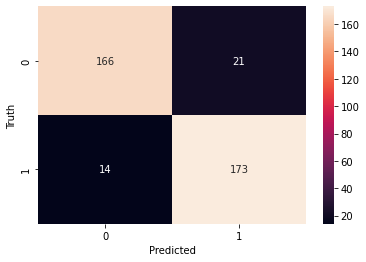

In [30]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       187
           1       0.89      0.93      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [44]:
reviews = [
      'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
       'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
      'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
      'Hey Sam, Are you coming for a cricket game tomorrow',
      "Why don't you wait 'til at least wednesday to see if you get your .",
      "Buy one, get one free $5600 booo, hurry up!!!"
]

x = model.predict(reviews)
x

array([[0.72894764],
       [0.8172728 ],
       [0.7498507 ],
       [0.19434655],
       [0.10658577],
       [0.5298964 ]], dtype=float32)

In [45]:
for i in x:
  if i > 0.5:
    print(1)
  else:
    print(0)


1
1
1
0
0
1
